In [ ]:
import os
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import glob  
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pyranges as pr
from kipoiseq import Interval
import pyfaidx
import kipoiseq
from collections import Counter
import gseapy as gp
import seaborn as sns
from memelite import tomtom, fimo
from memelite.io import read_meme
from memelite.utils import one_hot_encode
import gseapy as gp
import matplotlib as mpl # 
from matplotlib_venn import venn2, venn3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# %matplotlib inline

## GO Enrichment — comvar target genes (from link_var2gene.py)

In [ ]:
# Load comvar ABC-FP-Max results (top gene per variant)
comvar_max = pd.read_csv('results/var2gene_results/K562_comvar_ABC-FP-Max.csv')
print(f"Total variants with target genes: {len(comvar_max)}")

# Load max PIP from credible set files
cs_dir = 'data/GWFM_erythroids/credible_set_snpRes'
pip_dfs = []
for f in glob.glob(os.path.join(cs_dir, '*_credible_set_hg38.csv')):
    df = pd.read_csv(f, usecols=['Name', 'PIP'])
    pip_dfs.append(df)
pip_all = pd.concat(pip_dfs).groupby('Name')['PIP'].max().reset_index()
pip_all.columns = ['rsID', 'max_PIP']

# Load max PEP_cs directly from LCS files (not from PIP-filtered CSVs)
# A variant can be in a credible set for one trait but have high PIP in another
lcs_dir = 'data/GWFM_erythroids/lcs'
pep_rows = []
for f in glob.glob(os.path.join(lcs_dir, '*.lcs')):
    lcs = pd.read_csv(f, sep=r'\s+')
    lcs['SNP'] = lcs['SNP'].str.split(',')
    lcs = lcs.explode('SNP')
    pep_rows.append(lcs[['SNP', 'PEP']].rename(columns={'SNP': 'rsID', 'PEP': 'PEP_cs'}))
pep_all = pd.concat(pep_rows).groupby('rsID')['PEP_cs'].max().reset_index()

# Merge PIP and PEP_cs
comvar_max = comvar_max.merge(pip_all, on='rsID', how='left')
comvar_max = comvar_max.merge(pep_all, on='rsID', how='left')

# Filter: ABC.Score > 0.015, PIP > 0.1, variant in credible set (PEP_cs not NaN)
comvar_filtered = comvar_max[
    (comvar_max['ABC.Score'] > 0.015) &
    (comvar_max['max_PIP'] > 0.1) &
    (comvar_max['PEP_cs'].notna())
].reset_index(drop=True)
print(f"After ABC.Score > 0.015, PIP > 0.1, in credible set: {len(comvar_filtered)} variants, {comvar_filtered['TargetGene'].nunique()} unique genes")

gene_list_comvar = list(comvar_filtered['TargetGene'].unique())

# GO enrichment
enr_comvar = gp.enrichr(
    gene_list=gene_list_comvar,
    gene_sets='data/GSEA_MSigDB/c5.go.v2025.1.Hs.symbols.gmt',
    organism='Human',
    cutoff=0.05,
)
res2d_comvar = enr_comvar.res2d
go_comvar_sig = res2d_comvar[res2d_comvar['Adjusted P-value'] < 0.05].sort_values(
    by='Odds Ratio', ascending=False
).reset_index(drop=True)

go_comvar_sig['Term_split'] = go_comvar_sig['Term'].str.split('_').apply(
    lambda x: '_'.join(x[1:7]) + '\n' + '_'.join(x[7:]) if len(x) > 7 else '_'.join(x[1:])
)
go_comvar_sig['matched_gene'] = go_comvar_sig['Overlap'].str.split('/').str[0].astype(int)
go_comvar_sig['total_gene'] = go_comvar_sig['Overlap'].str.split('/').str[1].astype(int)
go_comvar_sig['matched_gene_prop'] = go_comvar_sig['matched_gene'] / go_comvar_sig['total_gene']
go_comvar_sig['pvalue_mlog10'] = -np.log10(go_comvar_sig['Adjusted P-value'])
print(f"Significant GO terms: {go_comvar_sig.shape[0]}")
go_comvar_sig.head(10)

/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_79731/1546025159.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


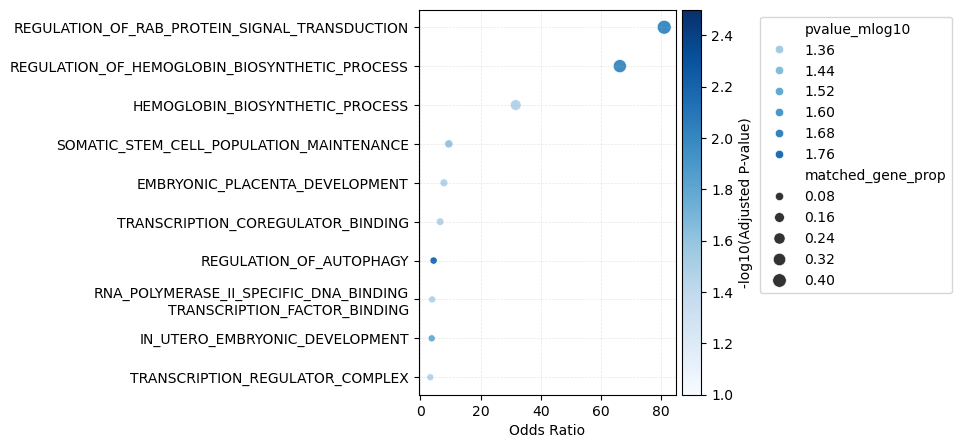

In [3]:
plt.figure(figsize=(4, 5))
scatter = sns.scatterplot(
    data=go_comvar_sig.head(10),
    x='Odds Ratio',
    y='Term_split',
    size='matched_gene_prop',
    hue='pvalue_mlog10',
    palette='Blues',
    sizes=(25, 100),
    hue_norm=(1, 2),
    legend='brief'
)
norm = mpl.colors.Normalize(vmin=1, vmax=2.5)
sm = mpl.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', pad=0.02)
cbar.set_label('-log10(Adjusted P-value)', rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), ncol=1, frameon=True)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.3)
plt.ylabel('')
plt.tight_layout()
# plt.savefig('results/var2gene_results/K562_comvar_go_enrichment.pdf', dpi=300, bbox_inches='tight')

### Validate filtered comvar target genes against reference

In [ ]:
# Compare filtered comvar results with reference
ref = pd.read_csv('data/results/K562_crediblevars_target_gene_full_for_go_enrichment.csv')
print(f"Our filtered: {len(comvar_filtered)} variants, {comvar_filtered['TargetGene'].nunique()} genes")
print(f"Reference:    {len(ref)} variants, {ref['TargetGene'].nunique()} genes")

our_ids = set(comvar_filtered['rsID'])
ref_ids = set(ref['rsID'])
shared = our_ids & ref_ids
only_ours = our_ids - ref_ids
only_ref = ref_ids - our_ids

print(f"\nShared rsIDs:       {len(shared)} / {len(ref_ids)} ({100*len(shared)/len(ref_ids):.1f}%)")
print(f"Only in ours:       {len(only_ours)}")
print(f"Only in reference:  {len(only_ref)}")

# Check gene agreement on shared rsIDs
our_genes = comvar_filtered.set_index('rsID')['TargetGene']
ref_genes = ref.set_index('rsID')['TargetGene']
matches = sum(our_genes[rid] == ref_genes[rid] for rid in shared)
print(f"Gene match (shared): {matches}/{len(shared)} ({100*matches/len(shared):.1f}%)")

if only_ref:
    print(f"\nrsIDs only in reference: {sorted(only_ref)}")
    for rid in sorted(only_ref):
        row = ref[ref['rsID'] == rid].iloc[0]
        print(f"  {rid} -> {row['TargetGene']} (ABC={row['ABC.Score']:.3f}, PIP={row['PIP']:.3f}, PEP_cs={row['PEP_cs']:.3f})")

## GO Enrichment — rarevar target genes (from link_var2gene.py)

In [4]:
# Load rarevar ABC-FP-Max results (top gene per variant)
rarevar_max = pd.read_csv('results/var2gene_results/K562_rarevar_ABC-FP-Max.csv')
rarevar_filtered = rarevar_max[rarevar_max['ABC.Score'] > 0.015].reset_index(drop=True)
gene_list_rarevar = list(rarevar_filtered['TargetGene'].unique())
print(f"Total rarevar variants: {len(rarevar_max)}, after ABC.Score > 0.015: {len(rarevar_filtered)}")
print(f"Unique target genes: {len(gene_list_rarevar)}")

# GO enrichment
enr_rarevar = gp.enrichr(
    gene_list=gene_list_rarevar,
    gene_sets='data/GSEA_MSigDB/c5.go.v2025.1.Hs.symbols.gmt',
    organism='Human',
    cutoff=0.05,
)
res2d_rarevar = enr_rarevar.res2d
go_rarevar_sig = res2d_rarevar[res2d_rarevar['Adjusted P-value'] < 0.05].sort_values(
    by='Odds Ratio', ascending=False
).reset_index(drop=True)

go_rarevar_sig['Term_split'] = go_rarevar_sig['Term'].str.split('_').apply(
    lambda x: '_'.join(x[1:7]) + '\n' + '_'.join(x[7:]) if len(x) > 7 else '_'.join(x[1:])
)
go_rarevar_sig['matched_gene'] = go_rarevar_sig['Overlap'].str.split('/').str[0].astype(int)
go_rarevar_sig['total_gene'] = go_rarevar_sig['Overlap'].str.split('/').str[1].astype(int)
go_rarevar_sig['matched_gene_prop'] = go_rarevar_sig['matched_gene'] / go_rarevar_sig['total_gene']
go_rarevar_sig['pvalue_mlog10'] = -np.log10(go_rarevar_sig['Adjusted P-value'])
print(f"Significant GO terms: {go_rarevar_sig.shape[0]}")
go_rarevar_sig.head(10)

Total rarevar variants: 19, after ABC.Score > 0.015: 18
Unique target genes: 14
Significant GO terms: 37


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Term_split,matched_gene,total_gene,matched_gene_prop,pvalue_mlog10
0,c5.go.v2025.1.Hs.symbols.gmt,GOMF_HAPTOGLOBIN_BINDING,3/10,2.131402e-08,0.000004,956.985965,16904.104981,HBZ;HBA2;HBQ1,HAPTOGLOBIN_BINDING,3,10,0.300000,5.387205
1,c5.go.v2025.1.Hs.symbols.gmt,GOCC_HAPTOGLOBIN_HEMOGLOBIN_COMPLEX,3/11,2.929663e-08,0.000004,844.356037,14646.025209,HBZ;HBA2;HBQ1,HAPTOGLOBIN_HEMOGLOBIN_COMPLEX,3,11,0.272727,5.387205
2,c5.go.v2025.1.Hs.symbols.gmt,GOCC_HEMOGLOBIN_COMPLEX,3/12,3.904865e-08,0.000004,755.437673,12886.601400,HBZ;HBA2;HBQ1,HEMOGLOBIN_COMPLEX,3,12,0.250000,5.387205
3,c5.go.v2025.1.Hs.symbols.gmt,GOMF_OXYGEN_CARRIER_ACTIVITY,3/14,6.456304e-08,0.000005,623.993135,10330.595583,HBZ;HBA2;HBQ1,OXYGEN_CARRIER_ACTIVITY,3,14,0.214286,5.293916
4,c5.go.v2025.1.Hs.symbols.gmt,GOBP_OXYGEN_TRANSPORT,3/15,8.067585e-08,0.000005,574.044211,9375.764529,HBZ;HBA2;HBQ1,OXYGEN_TRANSPORT,3,15,0.200000,5.293916
5,c5.go.v2025.1.Hs.symbols.gmt,GOMF_UDP_N_ACETYLGLUCOSAMINE_TRANSMEMBRANE_TRA...,1/5,3.073453e-03,0.034576,564.768116,3267.157291,SLC35B4,UDP_N_ACETYLGLUCOSAMINE_TRANSMEMBRANE_TRANSPOR...,1,5,0.200000,1.461221
6,c5.go.v2025.1.Hs.symbols.gmt,GOBP_NITRIC_OXIDE_TRANSPORT,1/5,3.073453e-03,0.034576,564.768116,3267.157291,HBA2,NITRIC_OXIDE_TRANSPORT,1,5,0.200000,1.461221
7,c5.go.v2025.1.Hs.symbols.gmt,GOMF_OXYGEN_SENSOR_ACTIVITY,1/5,3.073453e-03,0.034576,564.768116,3267.157291,EGLN2,OXYGEN_SENSOR_ACTIVITY,1,5,0.200000,1.461221
8,c5.go.v2025.1.Hs.symbols.gmt,GOBP_GMP_SALVAGE,1/5,3.073453e-03,0.034576,564.768116,3267.157291,APRT,GMP_SALVAGE,1,5,0.200000,1.461221
9,c5.go.v2025.1.Hs.symbols.gmt,GOBP_UDP_N_ACETYLGLUCOSAMINE_TRANSMEMBRANE_TRA...,1/5,3.073453e-03,0.034576,564.768116,3267.157291,SLC35B4,UDP_N_ACETYLGLUCOSAMINE_TRANSMEMBRANE_TRANSPORT,1,5,0.200000,1.461221


/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_79731/1408115499.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


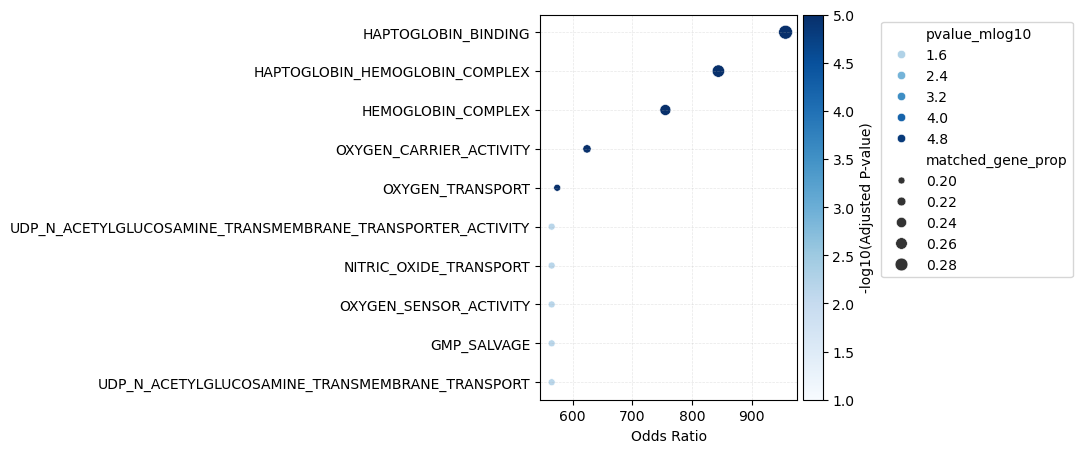

In [5]:
plt.figure(figsize=(4, 5))
scatter = sns.scatterplot(
    data=go_rarevar_sig.head(10),
    x='Odds Ratio',
    y='Term_split',
    size='matched_gene_prop',
    hue='pvalue_mlog10',
    palette='Blues',
    sizes=(25, 100),
    hue_norm=(0, 5),
    legend='brief'
)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
sm = mpl.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', pad=0.02)
cbar.set_label('-log10(Adjusted P-value)', rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), ncol=1, frameon=True)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.3)
plt.ylabel('')
plt.tight_layout()
#$ plt.savefig('results/var2gene_results/K562_rarevar_go_enrichment.pdf', dpi=300, bbox_inches='tight')